In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import style
import torch 
import torch.nn as nn
import torch.nn.functional as F


In [3]:
style.use('seaborn-darkgrid')
np.random.seed(42)


# Bayes For Gaussian Random Processes Part I

We will divide this study in 2 parts. The second part will deal with Neural Networks and hyperparameters. (Some of this code is based on the code from https://peterroelants.github.io/posts/gaussian-process-tutorial/)

Let $\phi(x) : x\in \mathbb{R}^d$.
The joint Prob. Density for a set of point $(t_1, \dots, t_n)$ is :

$p(\phi(t_1), \phi(t_2), \dots, \phi(t_n))$.

For a Gaussian Randon Field, $p$ is Gaussian :

$p(\phi(t_1), \phi(t_2), \dots, \phi(t_n)) = \frac{1}{\sqrt{(2\pi)^N|detC|}}exp[-\frac{1}{2}(\phi - \bar{\phi})^TC^{-1}(\phi - \bar{\phi})]$, with

$\bar{\phi_j} = <\phi_j>$, and
$C_{lj} = <(\phi - \bar{\phi})_l(\phi - \bar{\phi})_j>_p$

If we take a measurement $y_j$ at $j$, and assuming this is a Gaussian (measurement noise):

$p(y_j|\phi) = \frac{1}{\sqrt{2\pi}\sigma}exp[-\frac{1}{2\sigma^2}(y_j - \phi_j)^2]$.

Applying Bayes:

$p(\phi|y_j) = \frac{p(y_j|\phi)p(\phi)}{p(y_j)} = \frac{p(y_j|\phi)p(\phi)}{Normalization} => $ \
$log(p(\phi|y_j)) = cont - \frac{1}{2}\delta\phi^TC'^{-1}\delta\phi + (y_j - \bar{\phi}_j)\frac{\delta\phi_j}{\sigma^2}$

The new values of $C$, and $\bar{\phi}$ are

$\bar{\phi}' = \bar{\phi} + C'\ket{j}\frac{y_j - \bar{\phi_j}}{\sigma^2}$

$C'^{-1} = C^{-1} + \frac{1}{\sigma^2}\ket{j}\bra{j}$, where $(\ket{j})_l = \delta_{jl}$. 

We will make some new notations that will make it easier to define $C'$ for a finite set of measures $Y$. Let $Y$ be a set of new measures, $X$ be the old set of measures defining $C$, and lets take the joint distribution on the $(X,Y)$, where $C$ is the matrix with $C_{YY}, C_{XX}$ on the diagonals, and $C_{XY}, C_{YX}$ on the off diagonals. Then 

$\bar{\phi}_{X|Y} = \bar{\phi}_{X} + C_{XY}C^{-1}_{YY}(Y - \bar{\phi}_Y)$

$C_{X|Y} = C_{XX} - C_{XY}C^{-1}_{YY}C_{YX}$.

If we have a measument noise we have to add to $C_{YY}$  something like $\sigma^2\mathbb{I}$

We can further write

$C_{X|Y} = C_{XX} - (C^{-1}_{YY}C_{YX})^{T}C_{YX}$

$\bar{\phi}_{X|Y} = \bar{\phi}_{X} + (C_{YY}^{-1}C_{YX})^{T}(Y - \bar{\phi}_Y)$






In [4]:
# The most import ingredient that defines a gaussian process is it's kernel (C). We will start by exploring the quadratic kernel...
#  it gives a prior that the correlation between
#different point decreaeses exponetially:

In [5]:
# Kernel (Covariance Funtion k(x,x'))

def k(xa,xb):
    
    """ Quadratic Kernel"""

    return np.exp(-0.5*(xa[:,None]- xb)**2)

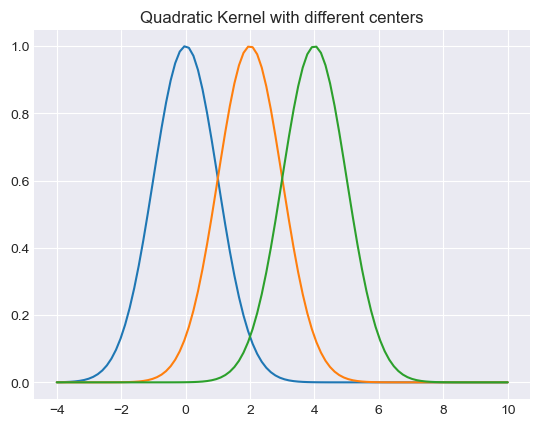

In [6]:
x =  np.linspace(-4,10,100)
for i in range(3):

    y = k(x,i*2)

    plt.plot(x,y)
    plt.title('Quadratic Kernel with different centers')

In [7]:
#To generate gaussian samples, we use np.random.multivariate_normal()

#For 50 samples 

X = np.linspace(-10,10,50)
sigma = k(X,X)

#We can draw 5 random process
mean = np.zeros_like(X)
y = np.random.multivariate_normal(
    mean= mean, cov = sigma,
    size=5)

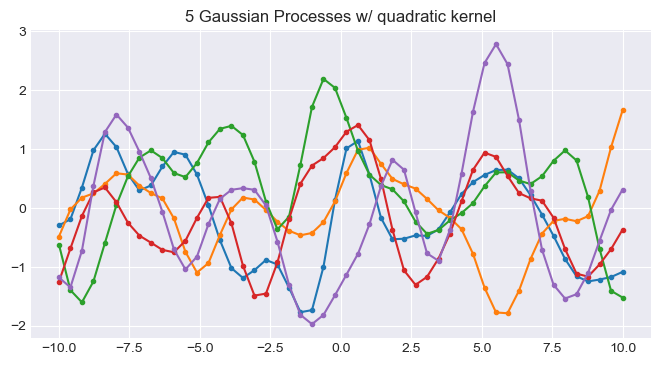

In [8]:
fig,ax = plt.subplots(
    nrows=1, ncols=1, figsize=(8, 4))

ax.plot(X,y.T,'-', marker ='o', markersize = 3)
plt.title('5 Gaussian Processes w/ quadratic kernel')
plt.show()

In [9]:
#Another famous distribution over the space of functions is the random walk:

Text(0.5, 1.0, 'Random Walk')

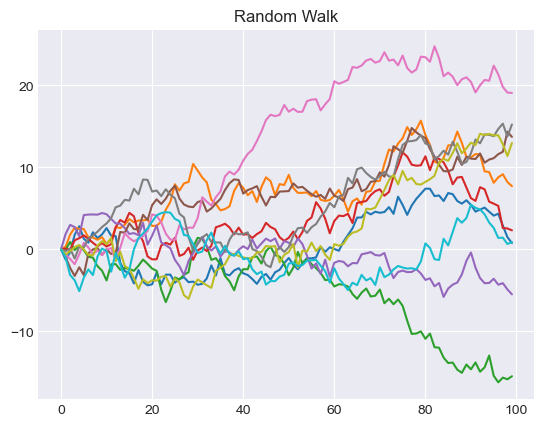

In [10]:
#Random walks

for j in range(10):

    d = 0
    y = []

    for i in range(100):
        y.append(d)
        dnew = np.random.randn()
        d = d + dnew

    plt.plot(y)
plt.title('Random Walk')    

In [12]:
#The random walk is also described by a gaussian process with Identity Kernel

In [13]:
#Now we will apply the bayesian update that we described in the beginning. For that we define the following function:

In [14]:
#Gaussian Posterior after measurement y

def GP(X1, y, X2, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y, X1), 
    and the prior kernel function.
    """
    # Kernel of the old observations
    C11 = kernel_func(X1, X1)

    # Kernel of old observations vs new
    C12 = kernel_func(X1, X2)

    inv = np.linalg.solve(C11, C12).T
    
    # Posterior mean

    meannew = inv @ y                  #We assume the gaussian have mean zero on X an Y
    
    # Compute the posterior covariance
    C22 = kernel_func(X2, X2)

    Cnew = C22 - (inv@C12)
    return meannew, Cnew  # mean, covariance

In [15]:
# Define the true function that we want to regress on
f_sin = lambda x: (np.sin(x)).flatten()

n1 = 8  # Number of points to condition on (observed points)
n2 = 75  # Number of points sampled in posterior (test points)
ny = 5  # Number of functions that will be sampled from the posterior
domain = (-6, 6)

# Sample observations (X1, y1) on the function
X1 = np.random.uniform(domain[0]+2, domain[1]-2, size=(n1))
y = f_sin(X1)

# Predict sample points at uniform spacing 
 
X2 = np.linspace(domain[0], domain[1], n2)

# Compute posterior mean and covariance
meannew, Cnew = GP(X1, y, X2, k)

# Compute the standard deviation at the test points to be plotted
sigma2 = np.sqrt(np.diag(Cnew))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=meannew, cov=Cnew, size=ny)

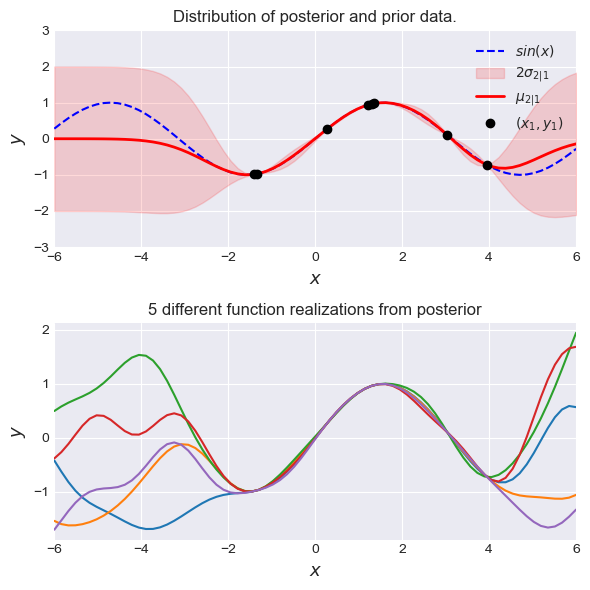

In [16]:
# Plot the postior distribution and some samples
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 6))
# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, f_sin(X2), 'b--', label='$sin(x)$')
ax1.fill_between(X2.flat, meannew-2*sigma2, meannew+2*sigma2, color='red', 
                 alpha=0.15, label='$2 \sigma_{2|1}$')
ax1.plot(X2, meannew, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(X1, y, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data.')
ax1.axis([domain[0], domain[1], -3, 3])
ax1.legend()
# Plot some samples from this function
ax2.plot(X2, y2.T, '-')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
ax1.axis([domain[0], domain[1], -3, 3])
ax2.set_xlim([-6, 6])
plt.tight_layout()
plt.show()

In [2]:
#Let's suppose now that we have a person lost in a 1D Tunnel, and from time to time we can look at a point of the tunnel and see if
#  the person is there.
#Let's say also that the person has more chance to be at the center (0) of the tunnel, since there is water there, and she is probably
#  thirsty. So 
#the unnormalized 'prob' prior for find this person in the tunnel should be something like this (in fact, to work with GPs and probabilities, we need to use a sigmoid layer and laplacian aproximation,
#  we will do it in the right way in part II):

In [17]:
X = np.linspace(-10,10,50)
C = k(X,X)

#We can draw 5 random process
mean = 3*np.exp(-0.1*(X)**2)           #More probability to be found at the center
y = np.random.multivariate_normal(
    mean= mean, cov = C,
    size=5)

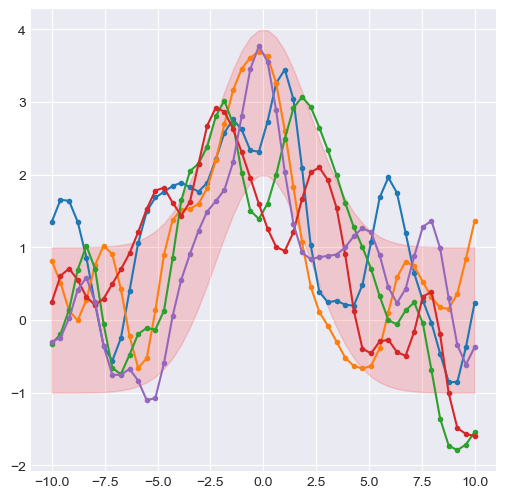

In [18]:
sigma2 = np.sqrt(np.diag(C))
fig,ax = plt.subplots(
    nrows=1, ncols=1, figsize=(6, 6))

ax.fill_between(X,mean -sigma2, mean +sigma2, color='red', 
                alpha=0.15, label='$2 \sigma_{2|1}$')

ax.plot(X,y.T,'-', marker ='o', markersize = 3)
plt.show()

In [19]:
#Now lets suppose we make 8 measuments in 8 diffent point of the tunnel, and we dont find the person

In [20]:
#Gaussian Posterior after measurement FOR NON-ZERO MEAN 

def GPfull(X1, y, X2,mean1,mean2, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y, X1), 
    and the prior kernel function.
    """
    # Kernel of the old observations
    C11 = kernel_func(X1, X1)

    # Kernel of old observations vs new
    C12 = kernel_func(X1, X2)

    inv = np.linalg.solve(C11, C12).T
    
    # Posterior mean

    meannew = mean2 + inv @ (y-mean1)                  
    
    # Compute the posterior covariance
    C22 = kernel_func(X2, X2)

    Cnew = C22 - (inv@C12)
    return meannew, Cnew  # mean, covariance

In [21]:
f = lambda x: np.zeros_like(x).flatten()            #the function should be always 0, meaning we dont find the person

n2 = 75  # Number of points sampled in posterior (test points)
ny = 5  # Number of functions that will be sampled from the posterior
domain = (-10, 10)

# Sample observations (X1, y) on the function
X1 = np.array([-10,10,8,0,-8,5,-5,2.5])               #measuments on the tunnel
y = f(X1)

# Predict sample points at uniform spacing 
 
X2 = np.linspace(domain[0], domain[1], n2)

mean1 = 3*np.exp(-0.1*(X1)**2)
mean2 = 3*np.exp(-0.1*(X2)**2)

# Compute posterior mean and covariance
meannew, Cnew = GPfull(X1, y, X2, mean1, mean2, k)

# Compute the standard deviation at the test points to be plotted
sigma2 = np.sqrt(np.diag(Cnew))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=meannew, cov=Cnew, size=ny)

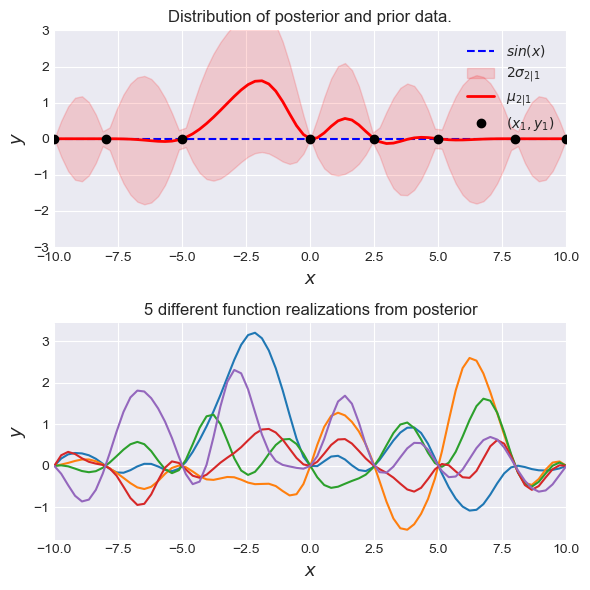

In [22]:
# Plot the postior distribution and some samples
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 6))
# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, f(X2), 'b--', label='$sin(x)$')
ax1.fill_between(X2.flat, meannew-2*sigma2, meannew+2*sigma2, color='red', 
                 alpha=0.15, label='$2 \sigma_{2|1}$')
ax1.plot(X2, meannew, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(X1, y, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data.')
ax1.axis([domain[0], domain[1], -3, 3])
ax1.legend()
# Plot some samples from this function
ax2.plot(X2, y2.T, '-')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
ax1.axis([domain[0], domain[1], -3, 3])
ax2.set_xlim([-10, 10])
plt.tight_layout()
plt.show()

In [19]:
#We see that since she was not at 0, the best place to look for her now is between -5 and 0.

In [23]:
#Now let's see the same problem, but the person is in a cave that can be described by a 2D map. 
# For that we will need to make a change on our kernel,
#so that it will work in 2D.

In [24]:
# Kernel (Covariance Funtion k(x,x')) for 2D

def k2d(xa,xb):
    
    """ Quadratic Kernel"""

    dist = ((xa[:,None] - xb)**2).sum(axis=-1)

    return np.exp(-0.5*dist)

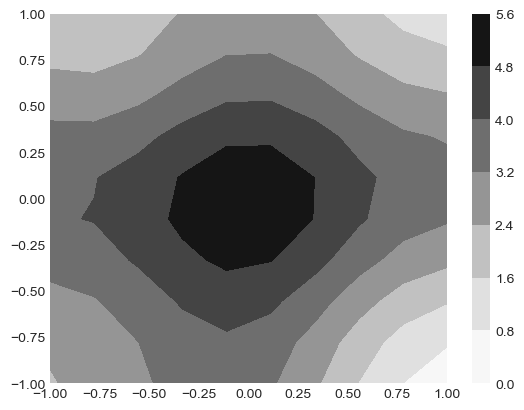

In [29]:
X = np.linspace(-1,1,10)

#The positions now are tuples
pos = []
for j in X:
    for i in X:
        pos.append([i,j])
pos = np.array(pos)

#Mean and Covariance
mean = 3*np.exp(-2*pos**2).sum(axis=-1)
C = k2d(pos,pos)

#Gaussian Process sampling
y = np.random.multivariate_normal(
    mean= mean, cov = C,
    size=1)
y = np.squeeze(y)

#Ploting the grid
X1, Y = np.meshgrid(X,X)
plt.contourf(X1,Y,y.reshape((X.size,X.size)))
plt.colorbar()


In [30]:
#Like before we have more chances of finding the person at the center of the cave. 
# Now we perform some measurements where we dont find the person.

In [31]:
f = lambda x: np.zeros(len(x)).flatten()                #measument = 0

n2 = 30  # Number of points sampled in posterior (test points)
ny = 5  # Number of functions that will be sampled from the posterior
domain = (-1, 1)

# Sample observations (X1, y1) on the function

X1= np.array([[0,1], [0,0], [0,0.5], [0,0.25],[1,0],[0.5,0],[0.25,0],[-1,-1]])

y = f(X1)

# Predict sample points at uniform spacing 
 
X2 = np.linspace(domain[0], domain[1], n2)

pos2 = []
for j in X2:
    for i in X2:
        pos2.append([i,j])
pos2 = np.array(pos2)

mean1 = 3*np.exp(-2*X1**2).sum(axis=-1)
mean2 = 3*np.exp(-2*pos2**2).sum(axis=-1)

# Compute posterior mean and covariance
meannew, Cnew = GPfull(X1, y, pos2, mean1, mean2, k2d)

# Compute the standard deviation at the test points to be plotted
sigma2 = np.sqrt(np.diag(Cnew))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=meannew, cov=Cnew, size=ny)

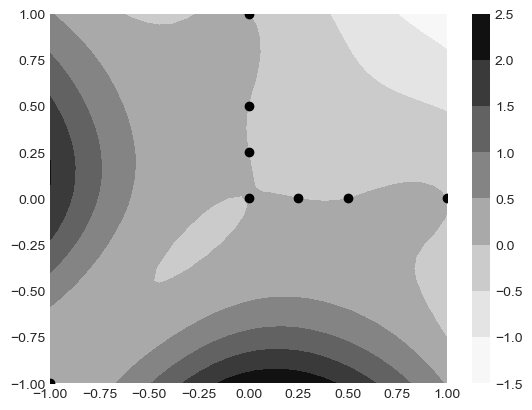

In [32]:
xmesh, ymesh = np.meshgrid(X2,X2)

u = (y2[0] + y2[1] + y2[2] +y2[3] + y2[4])/5         #We take the mean of all 5 samples 

plt.contourf(xmesh,ymesh,u.reshape((n2,n2)))
plt.colorbar()
plt.scatter(*X1.T, c='k')

Now we will explore some some other kernels. The kernels we are going to look are:

$k(x_a,x_b) = \sigma^2exp(-\frac{|x_a-x_b|^2}{2l^2})$ Exp Quadratic Kernel

$k(x_a,x_b) = \sigma^2exp(1 + \frac{|x_a-x_b|^2}{2l^2\alpha})^{-\alpha}$ Rational Quadratic Kernel

$k(x_a,x_b) = \sigma^2exp(-\frac{2}{l^2}sin^2(\pi\frac{|x_a-x_b|}{p}))$ Periodic Kernel

$k(x_a,x_b) = \sigma^2exp(-\frac{2}{l^2}sin^2(\pi\frac{|x_a-x_b|}{p}))exp(-\frac{|x_a-x_b|^2}{2l^2})$ Local Periodic Kernel

In [34]:
def expQK(xa,xb,sigma,l):
    x = sigma**2*np.exp(-(xa[:,None]-xb)**2/(2*l**2))
    return x

For the Exp Quadratic Kernel we have two parameters, $\sigma$, and l:\
$\sigma$ (amplitude or variance) gives the maximum value of the covariance.\
l (lenght scale) increases the spread of the covariance (the coupling between points)

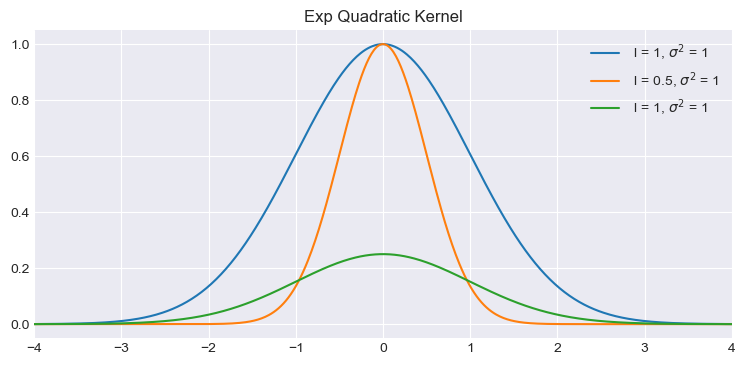

In [35]:
fig, ax = plt.subplots(figsize=(9,4))
x =  np.linspace(-4,10,1000)
ax.plot(x,expQK(x,0,1,1), label = " l = 1, $\sigma^2$ = 1")
ax.plot(x,expQK(x,0,1,0.5), label = " l = 0.5, $\sigma^2$ = 1")
ax.plot(x,expQK(x,0,0.5,1), label = " l = 1, $\sigma^2$ = 1" )
ax.set_xlim([-4,4]) 
plt.title('Exp Quadratic Kernel')
ax.legend();

In [36]:
# The gaussian process will look like:

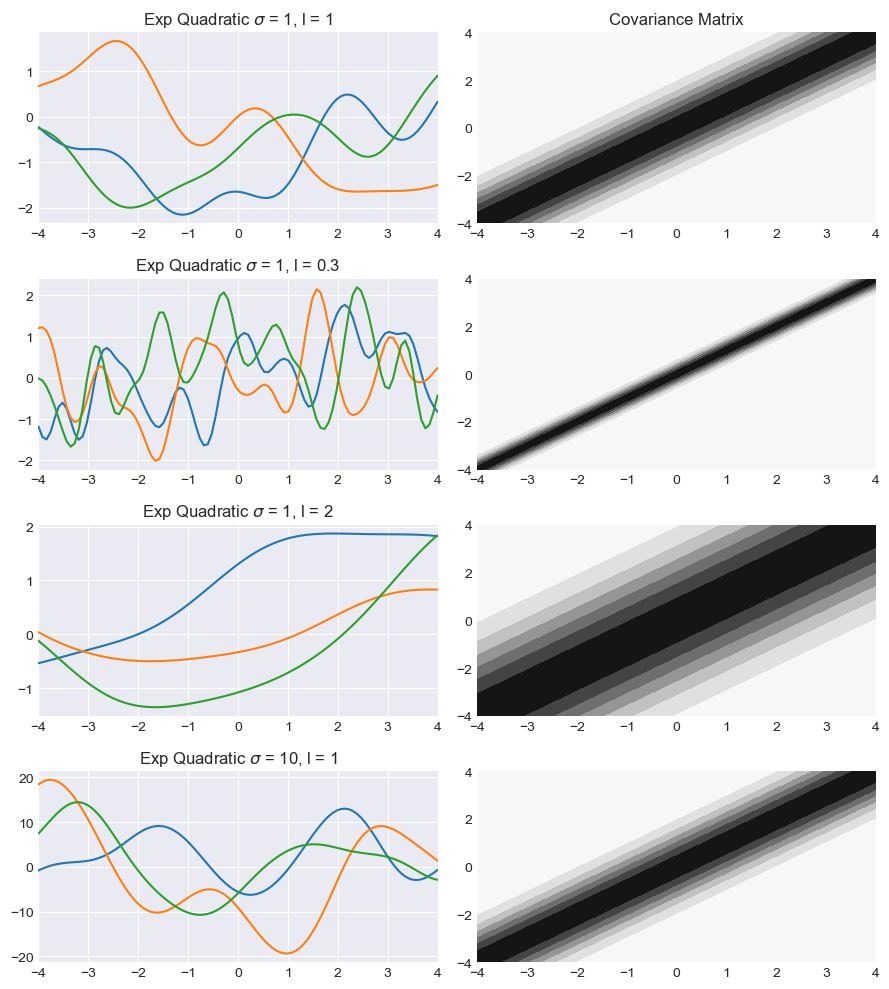

In [37]:
X = np.linspace(-4,4,100)
x,y = np.meshgrid(X,X)

sigma1 = expQK(X,X,1,1)
sigma2 = expQK(X,X,1,0.3)
sigma3 = expQK(X,X,1,2)
sigma4 = expQK(X,X,10,1)

mean = np.zeros_like(X)
y1 = np.random.multivariate_normal(
    mean= mean, cov = sigma1,
    size=3)

y2 = np.random.multivariate_normal(
    mean= mean, cov = sigma2,
    size=3)

y3 = np.random.multivariate_normal(
    mean= mean, cov = sigma3,
    size=3)

y4 = np.random.multivariate_normal(
    mean= mean, cov = sigma4,
    size=3)

fig,ax = plt.subplots(
    nrows=4, ncols=2, figsize=(9, 10))

ax[0,0].plot(X,y1.T,'-', markersize = 3)
ax[0,0].set_xlim([-4,4])
ax[0,0].set_title('Exp Quadratic $\sigma$ = 1, l = 1')
ax[1,0].plot(X,y2.T,'-', markersize = 3)
ax[1,0].set_xlim([-4,4])
ax[1,0].set_title('Exp Quadratic $\sigma$ = 1, l = 0.3')
ax[2,0].plot(X,y3.T,'-', markersize = 3)
ax[2,0].set_xlim([-4,4])
ax[2,0].set_title('Exp Quadratic $\sigma$ = 1, l = 2')
ax[3,0].plot(X,y4.T,'-', markersize = 3)
ax[3,0].set_xlim([-4,4])
ax[3,0].set_title('Exp Quadratic $\sigma$ = 10, l = 1')
ax[0,1].contourf(x,y,sigma1)
ax[0,1].set_title('Covariance Matrix')
ax[1,1].contourf(x,y,sigma2)
ax[2,1].contourf(x,y,sigma3)
ax[3,1].contourf(x,y,sigma4)
fig.tight_layout()
plt.show()

The Rational Quadratic Kernel have a new parametes $\alpha$ (scale mixture > 0). The kernel converges to the Exp Quadratic when $\alpha$ goes to infinity.\
Increasing $\alpha$ allows for local variations. 

In [38]:
def RQK(xa,xb,sigma,l, alpha):
    x = sigma**2*((1 + (xa[:,None]-xb)**2/(2*l**2*alpha))**(-alpha))
    return x

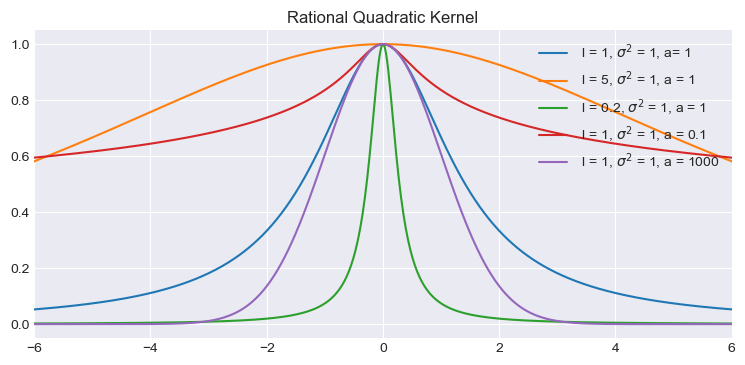

In [39]:
fig, ax = plt.subplots(figsize=(9,4))
x =  np.linspace(-10,10,1000)
ax.plot(x,RQK(x,0,1,1,1), label = " l = 1, $\sigma^2$ = 1, a= 1")
ax.plot(x,RQK(x,0,1,5,1), label = " l = 5, $\sigma^2$ = 1, a = 1")
ax.plot(x,RQK(x,0,1,0.2,1), label = " l = 0.2, $\sigma^2$ = 1, a = 1" )
ax.plot(x,RQK(x,0,1,1,0.1), label = " l = 1, $\sigma^2$ = 1, a = 0.1")
ax.plot(x,RQK(x,0,1,1,1000), label = " l = 1, $\sigma^2$ = 1, a = 1000" )
ax.set_xlim([-6,6])
ax.set_title('Rational Quadratic Kernel') 
ax.legend(loc = 1);

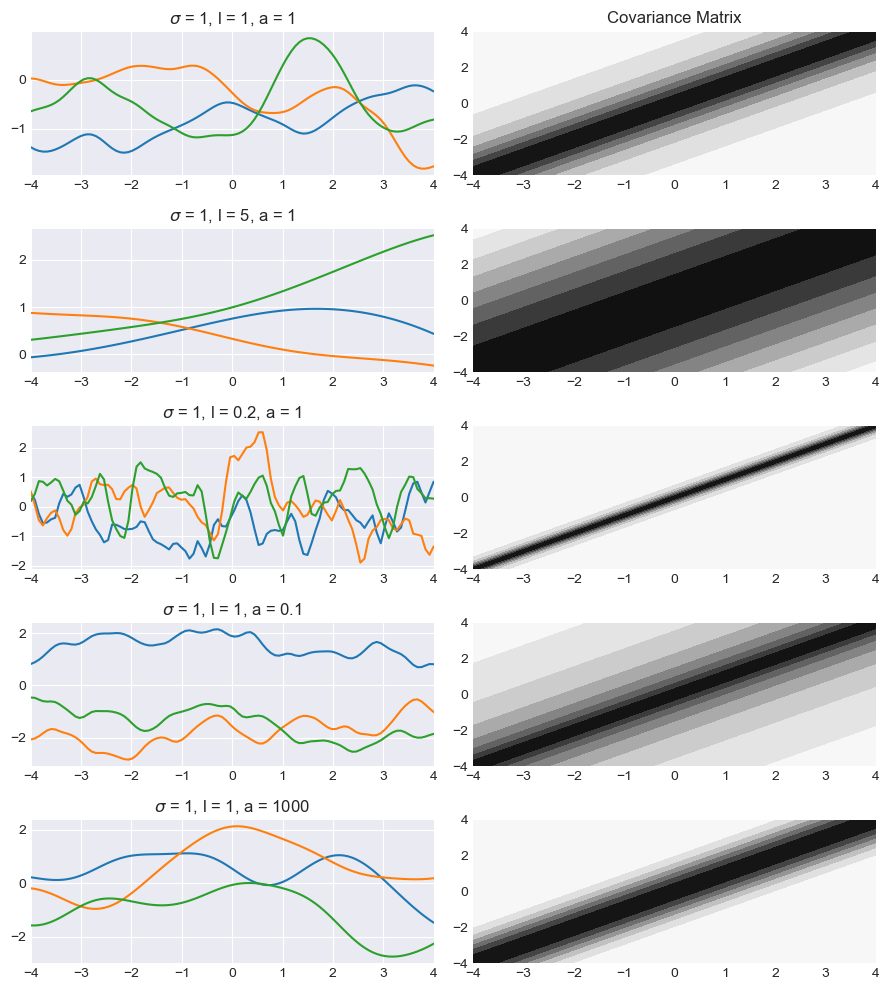

In [40]:
X = np.linspace(-4,4,100)
x,y = np.meshgrid(X,X)

sigma1 = RQK(X,X,1,1,1)
sigma2 = RQK(X,X,1,5,1)
sigma3 = RQK(X,X,1,0.2,1)
sigma4 = RQK(X,X,1,1,0.1)
sigma5 = RQK(X,X,1,1,1000)


mean = np.zeros_like(X)
y1 = np.random.multivariate_normal(
    mean= mean, cov = sigma1,
    size=3)

y2 = np.random.multivariate_normal(
    mean= mean, cov = sigma2,
    size=3)

y3 = np.random.multivariate_normal(
    mean= mean, cov = sigma3,
    size=3)

y4 = np.random.multivariate_normal(
    mean= mean, cov = sigma4,
    size=3)

y5 = np.random.multivariate_normal(
    mean= mean, cov = sigma5,
    size=3)

fig,ax = plt.subplots(
    nrows=5, ncols=2, figsize=(9, 10))

ax[0,0].plot(X,y1.T,'-', markersize = 3)
ax[0,0].set_xlim([-4,4])
ax[0,0].set_title('$\sigma$ = 1, l = 1, a = 1')
ax[1,0].plot(X,y2.T,'-', markersize = 3)
ax[1,0].set_xlim([-4,4])
ax[1,0].set_title('$\sigma$ = 1, l = 5, a = 1')
ax[2,0].plot(X,y3.T,'-', markersize = 3)
ax[2,0].set_xlim([-4,4])
ax[2,0].set_title('$\sigma$ = 1, l = 0.2, a = 1')
ax[3,0].plot(X,y4.T,'-', markersize = 3)
ax[3,0].set_xlim([-4,4])
ax[3,0].set_title('$\sigma$ = 1, l = 1, a = 0.1')
ax[4,0].plot(X,y5.T,'-', markersize = 3)
ax[4,0].set_xlim([-4,4])
ax[4,0].set_title('$\sigma$ = 1, l = 1, a = 1000')
ax[0,1].contourf(x,y,sigma1)
ax[0,1].set_title('Covariance Matrix')
ax[1,1].contourf(x,y,sigma2)
ax[2,1].contourf(x,y,sigma3)
ax[3,1].contourf(x,y,sigma4)
ax[4,1].contourf(x,y,sigma5)

fig.tight_layout()
plt.show()


The periodic kernel have a new parameter p that controls the frequency

In [41]:
def periodic(xa,xb,sigma,l, p):
    x = sigma**2*np.exp(-2/l**2*np.sin(np.pi*np.absolute(xa[:,None] - xb)/p)**2)
    return x 

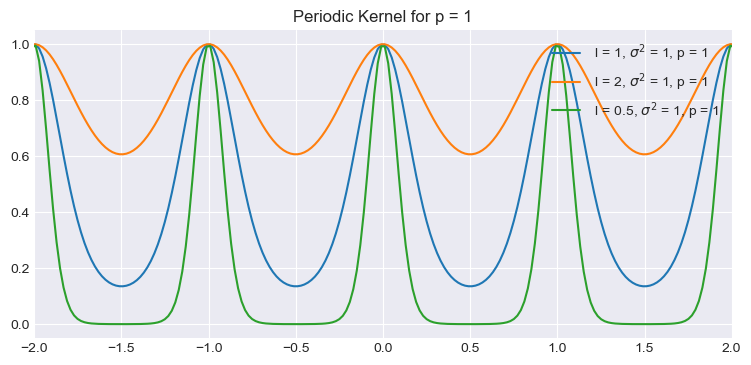

In [42]:
fig, ax = plt.subplots(figsize=(9,4))
x =  np.linspace(-10,10,1000)
ax.plot(x,periodic(x,0,1,1,1), label = " l = 1, $\sigma^2$ = 1, p = 1")
ax.plot(x,periodic(x,0,1,2,1), label = " l = 2, $\sigma^2$ = 1, p = 1")
ax.plot(x,periodic(x,0,1,0.5,1), label = " l = 0.5, $\sigma^2$ = 1, p = 1" )
ax.set_xlim([-2,2]) 
ax.legend(loc=1)
plt.title('Periodic Kernel for p = 1');

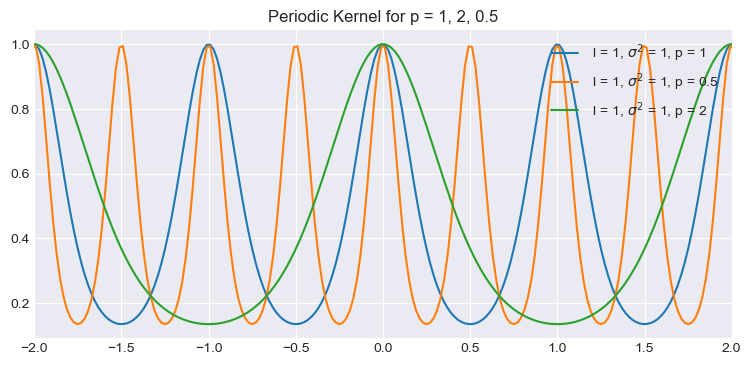

In [43]:
fig, ax = plt.subplots(figsize=(9,4))
x =  np.linspace(-10,10,1000)
ax.plot(x,periodic(x,0,1,1,1), label = " l = 1, $\sigma^2$ = 1, p = 1")
ax.plot(x,periodic(x,0,1,1,0.5), label = " l = 1, $\sigma^2$ = 1, p = 0.5")
ax.plot(x,periodic(x,0,1,1,2), label = " l = 1, $\sigma^2$ = 1, p = 2" )
ax.set_xlim([-2,2]) 
plt.title('Periodic Kernel for p = 1, 2, 0.5')
ax.legend(loc=1);

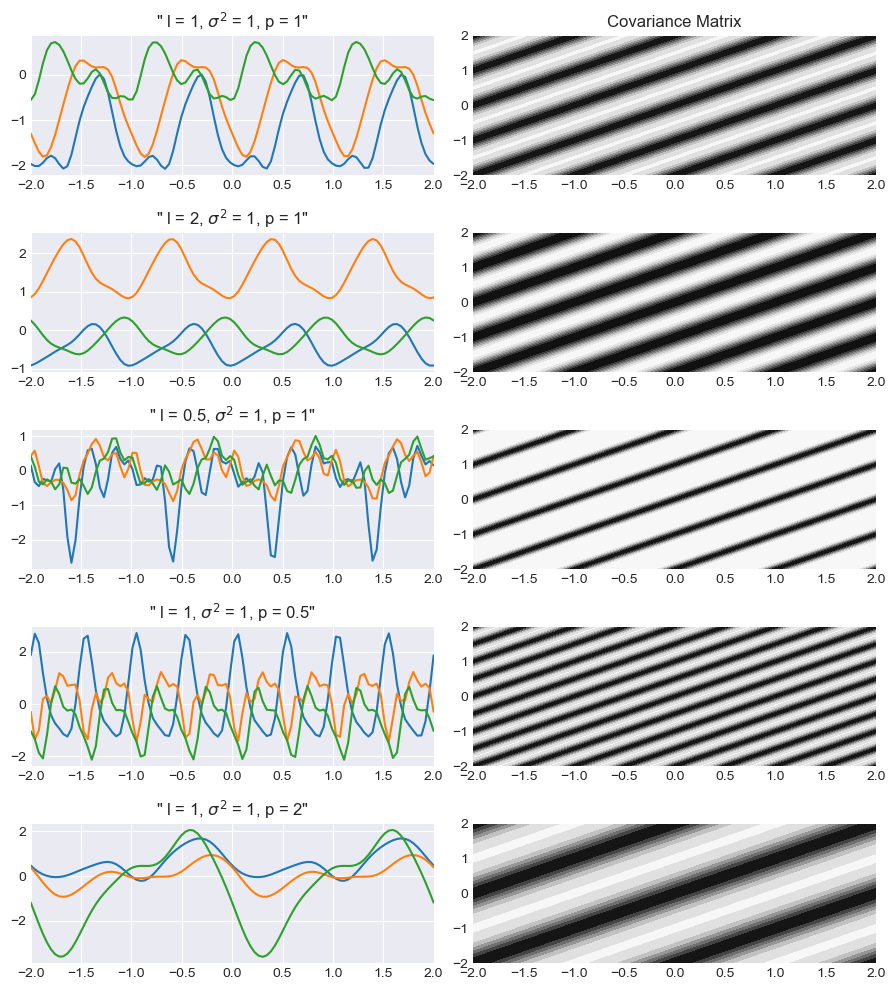

In [44]:
X = np.linspace(-2,2,100)
x,y = np.meshgrid(X,X)


sigma1 = periodic(X,X,1,1,1)
sigma2 = periodic(X,X,1,2,1)
sigma3 = periodic(X,X,1,0.5,1)
sigma4 = periodic(X,X,1,1,0.5)
sigma5 = periodic(X,X,1,1,2)


mean = np.zeros_like(X)
y1 = np.random.multivariate_normal(
    mean= mean, cov = sigma1,
    size=3)

y2 = np.random.multivariate_normal(
    mean= mean, cov = sigma2,
    size=3)

y3 = np.random.multivariate_normal(
    mean= mean, cov = sigma3,
    size=3)

y4 = np.random.multivariate_normal(
    mean= mean, cov = sigma4,
    size=3)

y5 = np.random.multivariate_normal(
    mean= mean, cov = sigma5,
    size=3)

fig,ax = plt.subplots(
    nrows=5, ncols=2, figsize=(9, 10))

ax[0,0].plot(X,y1.T,'-', markersize = 3)
ax[0,0].set_xlim([-2,2])
ax[0,0].set_title('" l = 1, $\sigma^2$ = 1, p = 1"')
ax[1,0].plot(X,y2.T,'-', markersize = 3)
ax[1,0].set_xlim([-2,2])
ax[1,0].set_title('" l = 2, $\sigma^2$ = 1, p = 1"')
ax[2,0].plot(X,y3.T,'-', markersize = 3)
ax[2,0].set_xlim([-2,2])
ax[2,0].set_title('" l = 0.5, $\sigma^2$ = 1, p = 1"')
ax[3,0].plot(X,y4.T,'-', markersize = 3)
ax[3,0].set_xlim([-2,2])
ax[3,0].set_title('" l = 1, $\sigma^2$ = 1, p = 0.5"')
ax[4,0].plot(X,y5.T,'-', markersize = 3)
ax[4,0].set_xlim([-2,2])
ax[4,0].set_title('" l = 1, $\sigma^2$ = 1, p = 2"')
ax[0,1].contourf(x,y,sigma1)
ax[0,1].set_title('Covariance Matrix')
ax[1,1].contourf(x,y,sigma2)
ax[2,1].contourf(x,y,sigma3)
ax[3,1].contourf(x,y,sigma4)
ax[4,1].contourf(x,y,sigma5)
fig.tight_layout()

plt.show()

We can obtain new kernels by multiplying 2 kernels, this will give us a new kernel that inherits similarities from both kernels.\
The local kernal is a mixture of the periodic kernal, and the quadratic kernel. It is essencially a periodic function with exponential decay.

In [45]:
def local(xa,xb,sigma,l1,p,l2):
    x = sigma**2*np.exp(-2/l1**2*np.sin(np.pi*np.absolute(xa[:,None] - xb)/p)**2)*np.exp(-(xa[:,None]-xb)**2/(2*l2**2))
    return x

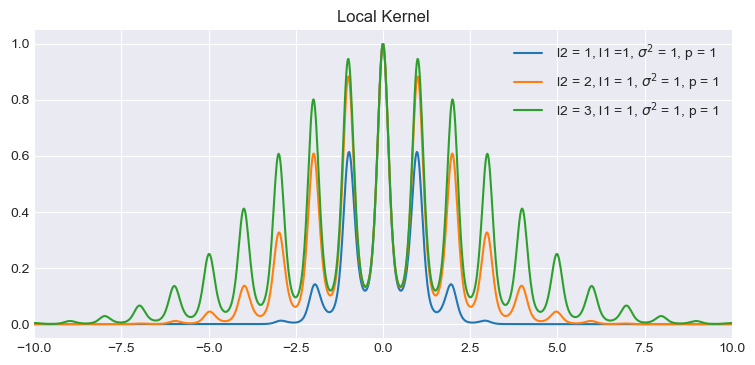

In [46]:
fig, ax = plt.subplots(figsize=(9,4))
x =  np.linspace(-10,10,1000)
ax.plot(x,local(x,0,1,1,1,1), label = " l2 = 1, l1 =1, $\sigma^2$ = 1, p = 1")
ax.plot(x,local(x,0,1,1,1,2), label = " l2 = 2, l1 = 1, $\sigma^2$ = 1, p = 1")
ax.plot(x,local(x,0,1,1,1,3), label = " l2 = 3, l1 = 1, $\sigma^2$ = 1, p = 1" )
ax.set_xlim([-10,10])
plt.title('Local Kernel') 
ax.legend(loc=1);

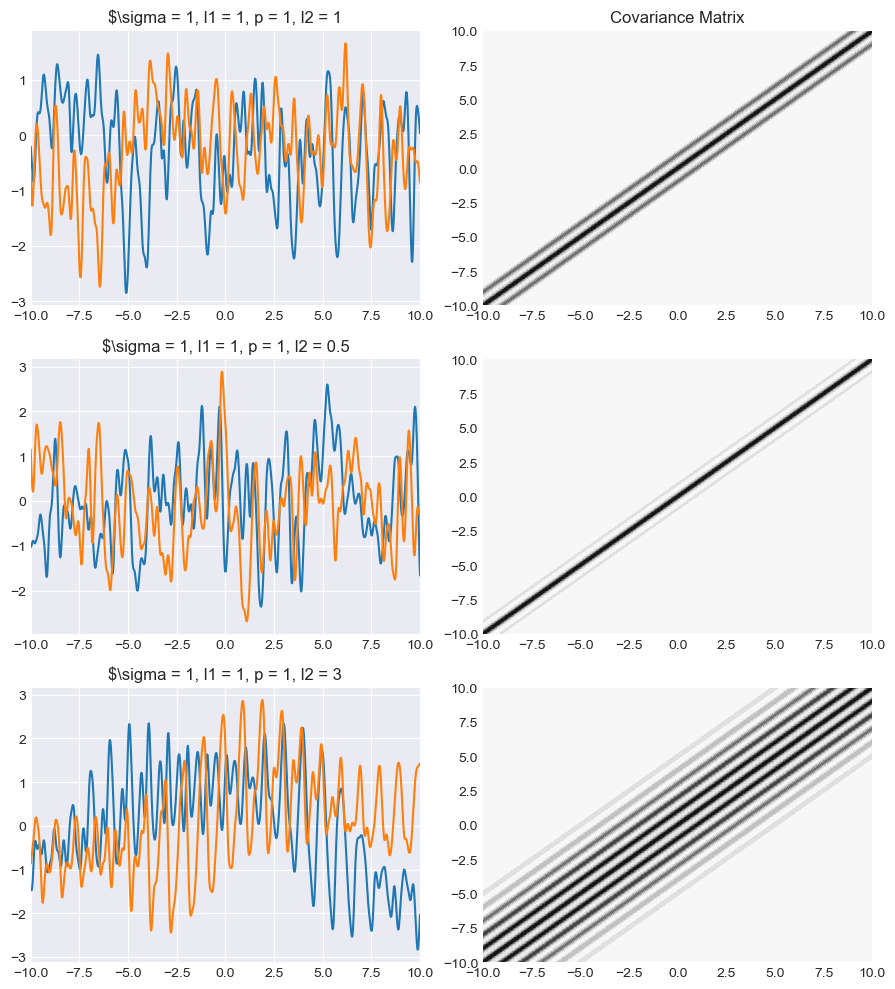

In [47]:
X = np.linspace(-10,10,1000)
x,y = np.meshgrid(X,X)


sigma1 = local(X,X,1,1,1,1)
sigma2 = local(X,X,1,1,1,0.5)
sigma3 = local(X,X,1,1,1,3)


mean = np.zeros_like(X)
y1 = np.random.multivariate_normal(
    mean= mean, cov = sigma1,
    size=2)

y2 = np.random.multivariate_normal(
    mean= mean, cov = sigma2,
    size=2)

y3 = np.random.multivariate_normal(
    mean= mean, cov = sigma3,
    size=2)

fig,ax = plt.subplots(
    nrows=3, ncols=2, figsize=(9, 10))

ax[0,0].plot(X,y1.T,'-', markersize = 3)
ax[0,0].set_xlim([-10,10])
ax[0,0].set_title('$\sigma = 1, l1 = 1, p = 1, l2 = 1')
ax[1,0].plot(X,y2.T,'-', markersize = 3)
ax[1,0].set_xlim([-10,10])
ax[1,0].set_title('$\sigma = 1, l1 = 1, p = 1, l2 = 0.5')
ax[2,0].plot(X,y3.T,'-', markersize = 3)
ax[2,0].set_xlim([-10,10])
ax[2,0].set_title('$\sigma = 1, l1 = 1, p = 1, l2 = 3')
ax[0,1].contourf(x,y,sigma1)
ax[0,1].set_title('Covariance Matrix')
ax[1,1].contourf(x,y,sigma2)
ax[2,1].contourf(x,y,sigma3)
fig.tight_layout()



plt.show()

# This is the part 2 and is incomplete... please search for the complete part 2 at my github https://github.com/PastryDoll

The prior kernels are chosen accordingly to the problem we want to fit. Now we will give a real life example of how to use these kernels.\
The data consists of CO2 (ppm) measurements X Year in Mauna Loa

In [2]:
import pandas as pd
        
# Load the data
# Load the data from the Scripps CO2 program website. 
co2_df = pd.read_csv(
    # Source: https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv
    './monthly_in_situ_co2_mlo.csv', 
    header=2,
    usecols=[3, 4], # Only keep the 'Date' and 'CO2' columns
    na_values='-99.99',  # NaNs are denoted as '-99.99'
    dtype=np.float64

)
co2_df.dropna(inplace=True)
co2_df.columns = ['Year', 'CO2(ppm)']

co2_df.head()

,Year,CO2(ppm)
2,1958.2027,315.71
3,1958.2877,317.45
4,1958.3699,317.51
6,1958.5370,315.87
7,1958.6219,314.93


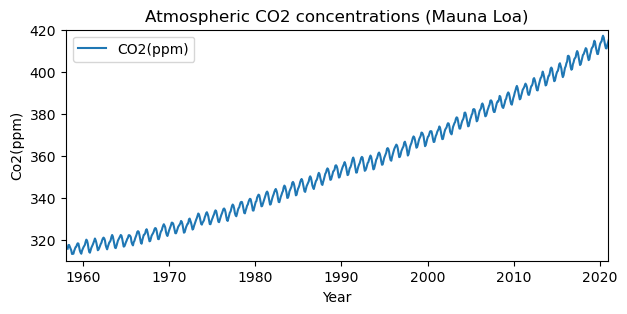

In [3]:
co2_df.plot(0, figsize=(7,3), title='Atmospheric CO2 concentrations (Mauna Loa)', ylabel='Co2(ppm)', xlim=(1958, 2021), ylim=(310, 420));

In [148]:
#Now we split our data into the observed data, and the test data:

In [15]:
# Split the data into observed and to predict
date_split_predict = 2010
df_observed = co2_df[co2_df.Year < date_split_predict]
print('{} measurements in the observed set'.format(len(df_observed)))
df_predict = co2_df[co2_df.Year >= date_split_predict]
print('{} measurements in the test set'.format(len(df_predict)))

617 measurements in the observed set
151 measurements in the test set


In [46]:
# We can see that our data have some kind of periodicity and overall growth.

In [164]:
class kernel(nn.Module):
    
    def __init__(self):
        super(kernel,self).__init__()

        w = torch.empty(9)
        torch.nn.init.uniform_(w, a=0.1, b=1.0)

        self.sigma1 = nn.Parameter(torch.Tensor([1]))
        # self.sigma2 = nn.Parameter(w[1])
        # self.sigma3 = nn.Parameter(w[2])
        self.p = nn.Parameter(torch.Tensor([1]))
        self.l1 = nn.Parameter(torch.Tensor([1]))
        # self.l2 = nn.Parameter(w[5])
        # self.l3 = nn.Parameter(w[6])
        # self.l4  = nn.Parameter(w[7])
        # self.alpha = nn.Parameter(w[8])

    def forward(self, xa, xb):
    
        d = torch.abs(xa[:,None] - xb)
        x = self.sigma1**2*torch.exp(-2/self.l1**2*torch.sin(torch.pi*d/self.p)**2) #*torch.exp(-d**2/(2*self.l2**2))
        # x += self.sigma2**2*((1 + d**2/(2*self.l3**2*self.alpha))**(-self.alpha))
        # x += self.sigma3**2*torch.exp(-d**2/(2*self.l4**2))

        return x

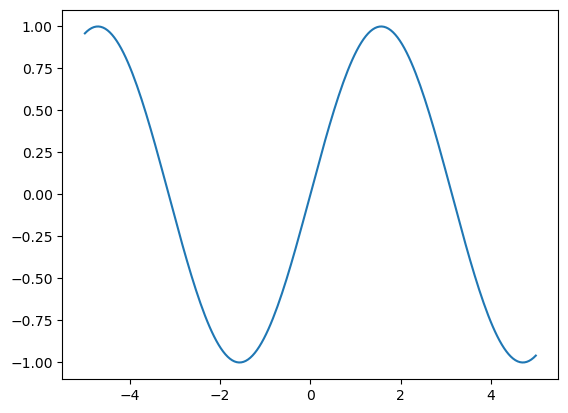

In [150]:
X = torch.linspace(-5,5,200)
Y = torch.sin(X)
plt.plot(X,Y)

In [151]:
K = kernel()

In [165]:
list(K.parameters())

[Parameter containing:
 tensor([1.], requires_grad=True),
 Parameter containing:
 tensor([1.], requires_grad=True),
 Parameter containing:
 tensor([1.], requires_grad=True)]

In [153]:
def periodic(xa,xb,sigma,l, p):
    x = sigma**2*np.exp(-2/l**2*np.sin(np.pi*np.absolute(xa[:,None] - xb)/p)**2)
    return x 

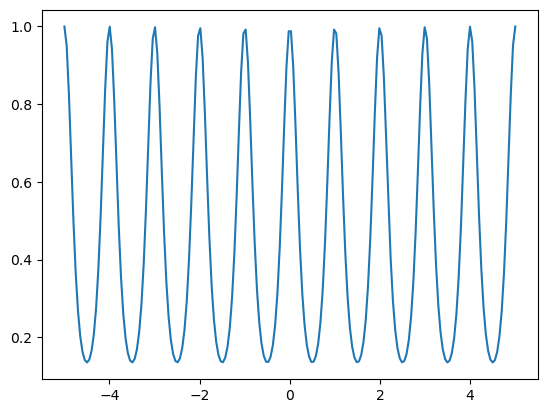

In [167]:
plt.plot(X,periodic(X,0,1,1,1))

In [297]:
X = np.linspace(0.1,1,10)
mena = np.zeros_like(X)
y = periodic(X,X,1,1,1)
d = np.random.multivariate_normal(mena, y, size=2)
np.linalg.eigvals(y)

array([4.65759608e+00, 2.07910417e+00, 2.07910417e+00, 1.99731428e-03,
       4.99388135e-01, 4.99388135e-01, 8.15589609e-02, 8.15589609e-02,
       1.01520337e-02, 1.01520337e-02])

In [298]:
K(X,X)
mean = torch.zeros_like(X)


TypeError: abs(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [300]:
(X[:,None]@X[:,None].T)

array([[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ],
       [0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ],
       [0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.3 ],
       [0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ],
       [0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ],
       [0.06, 0.12, 0.18, 0.24, 0.3 , 0.36, 0.42, 0.48, 0.54, 0.6 ],
       [0.07, 0.14, 0.21, 0.28, 0.35, 0.42, 0.49, 0.56, 0.63, 0.7 ],
       [0.08, 0.16, 0.24, 0.32, 0.4 , 0.48, 0.56, 0.64, 0.72, 0.8 ],
       [0.09, 0.18, 0.27, 0.36, 0.45, 0.54, 0.63, 0.72, 0.81, 0.9 ],
       [0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 1.  ]])

In [301]:
np.linalg.eig(X[:,None]@X[:,None].T)

(array([-4.44089210e-16,  3.85000000e+00, -3.91631586e-17,  9.24560551e-17,
         1.25048112e-17,  6.45473782e-18, -5.32727466e-18, -2.60404579e-31,
         4.51544687e-33, -2.38729972e-33]),
 array([[-9.98700454e-01, -5.09647191e-02, -3.43292418e-03,
         -1.34200270e-02, -1.21701205e-03, -6.60943212e-04,
         -8.71064986e-05, -4.92766375e-18, -1.92341563e-20,
          2.71737091e-18],
        [ 5.20156487e-03, -1.01929438e-01,  7.11919365e-02,
         -1.56095174e-01, -8.90997667e-02, -9.25051772e-02,
          1.43862502e-02, -5.70200124e-15, -7.09096382e-16,
          5.34212334e-16],
        [ 7.80234730e-03, -1.52894157e-01,  3.81817354e-01,
          7.69260103e-02, -7.80675802e-02,  2.16863431e-01,
         -1.54064683e-01, -8.59871624e-01,  7.66419944e-02,
         -1.02888004e-01],
        [ 1.04031297e-02, -2.03858877e-01,  1.42383873e-01,
         -3.12190347e-01, -1.78199533e-01, -1.85010354e-01,
          2.87725004e-02,  1.02308551e-01, -3.10137975e-01,
   

In [291]:
np.linalg.cholesky(X[:,None]@X[:,None].T)

LinAlgError: Matrix is not positive definite

In [257]:
X = torch.linspace(0,1,100)
mean = torch.zeros_like(X)
K = kernel()
m = torch.distributions.multivariate_normal.MultivariateNormal(mean,K(X,X))

ValueError: Expected parameter covariance_matrix (Tensor of shape (100, 100)) of distribution MultivariateNormal(loc: torch.Size([100]), covariance_matrix: torch.Size([100, 100])) to satisfy the constraint PositiveDefinite(), but found invalid values:
tensor([[1.0000, 0.9980, 0.9920,  ..., 0.9920, 0.9980, 1.0000],
        [0.9980, 1.0000, 0.9980,  ..., 0.9821, 0.9920, 0.9980],
        [0.9920, 0.9980, 1.0000,  ..., 0.9685, 0.9821, 0.9920],
        ...,
        [0.9920, 0.9821, 0.9685,  ..., 1.0000, 0.9980, 0.9920],
        [0.9980, 0.9920, 0.9821,  ..., 0.9980, 1.0000, 0.9980],
        [1.0000, 0.9980, 0.9920,  ..., 0.9920, 0.9980, 1.0000]],
       grad_fn=<ExpandBackward0>)

C:\Users\Dell\AppData\Local\Temp\ipykernel_19352\2321060961.py:4: RuntimeWarning: covariance is not positive-semidefinite.
  y1 = np.random.multivariate_normal(


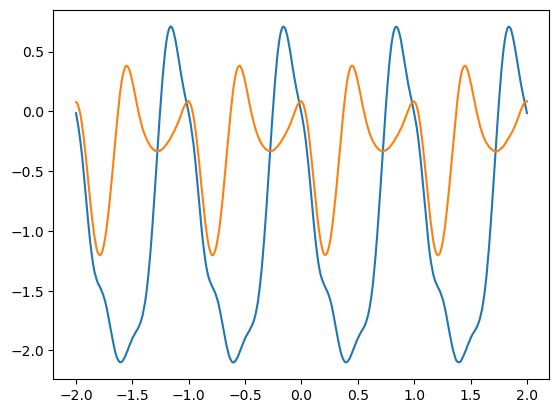

In [211]:
X = torch.linspace(-2,2,1000)
mean = np.zeros_like(X)

y1 = np.random.multivariate_normal(
    mean= mean, cov = K(X,X).detach().numpy(),
    size=2)

plt.plot(X,y1.T,'-');

In [762]:
K = kernel()
X = torch.Tensor(df_observed['Year'].to_numpy())
Y = torch.Tensor(df_observed['CO2(ppm)'].to_numpy())
K(X,X)

tensor([[3.5332e+03, 3.5122e+03, 3.4528e+03,  ..., 6.2109e-03, 6.2026e-03,
         6.1947e-03],
        [3.5122e+03, 3.5332e+03, 3.5136e+03,  ..., 6.2192e-03, 6.2109e-03,
         6.2029e-03],
        [3.4528e+03, 3.5136e+03, 3.5332e+03,  ..., 6.2273e-03, 6.2189e-03,
         6.2109e-03],
        ...,
        [6.2109e-03, 6.2192e-03, 6.2273e-03,  ..., 3.5332e+03, 3.5121e+03,
         3.4526e+03],
        [6.2026e-03, 6.2109e-03, 6.2189e-03,  ..., 3.5121e+03, 3.5332e+03,
         3.5136e+03],
        [6.1947e-03, 6.2029e-03, 6.2109e-03,  ..., 3.4526e+03, 3.5136e+03,
         3.5332e+03]], grad_fn=<AddBackward0>)

C:\Users\Dell\AppData\Local\Temp\ipykernel_5500\1160573080.py:6: RuntimeWarning: covariance is not positive-semidefinite.
  y1 = np.random.multivariate_normal(


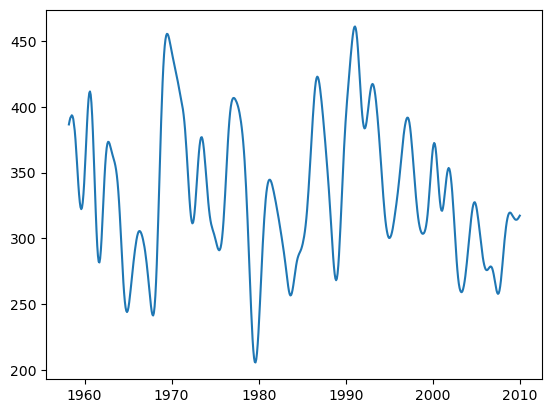

In [763]:
X = torch.Tensor(df_observed['Year'].to_numpy())
Y = torch.Tensor(df_observed['CO2(ppm)'].to_numpy())

mean = torch.ones_like(X)*torch.mean(Y)

y1 = np.random.multivariate_normal(
    mean= mean, cov = K(X,X).detach().numpy(),
    size=1)

plt.plot(X,y1.T,'-');


In [766]:
A =  torch.linalg.solve(K(X,X), (Y-mean))
-1/2*(Y-mean).T@A - 1/2*(torch.det(K(X,X)) + 0.0001).log()

tensor(1275.1208, grad_fn=<SubBackward0>)

In [44]:
epochs = 100

for epochs in range(epochs):

    total = 0
    A =  torch.linalg.solve(K(X,X), (Y-mean))
    py = -1/2*(Y-mean).T@A - 1/2*(torch.det(K(X,X)) + 0.0001).log()
    loss = - py
    optim = torch.optim.Adam(params = K.parameters(), lr = 0.01 )
    optim.zero_grad()
    loss.backward()
    optim.step()
    total += loss.item() 
    print(total)
    

10868379.0
12305584.0
-5487172.0
30620456.0
-6671242.5
7491097.5
-5937066.0
4479410.5
-6379270.5
89218608.0
-6506312.5
14983253.0
-11250940.0
87434792.0
3645584.5
-4776021.5
-1480684.375
-6564049.0
-3256684.75
5784579.5
-4202770.5
960561.125
5925529.5
4591631.5
4738980.5
-17949366.0
-6556701.0
-19337652.0
-4488101.5
-12090971.0
-80651072.0
-14351109.0
-80651072.0
-14351109.0
-80651072.0
-14351109.0
-80651072.0
-14351109.0
-80651072.0
-14351109.0
-80651072.0
-14351109.0
-80651072.0
-14351109.0
-80651072.0
-14351109.0
-80651072.0
-14351109.0
-80651072.0
-14351109.0
-80651072.0
-14351109.0
-80651072.0
-14351109.0
-80651072.0
-14351109.0
-80651072.0
-14351109.0
-80651072.0
-14351109.0
-80651072.0
-14351109.0
-80651072.0
-14351109.0
-80651072.0
-14351109.0
-80651072.0
-14351109.0
-80651072.0
-14351109.0
-80651072.0
-14351109.0
-80651072.0
-14351109.0
-80651072.0
-14351109.0
-80651072.0
-14351109.0
-80651072.0
-14351109.0
-80651072.0
-14351109.0
-80651072.0
-14351109.0
-80651072.0
-14351109.

In [758]:
list(K.parameters())

[Parameter containing:
 tensor(0.6676, requires_grad=True),
 Parameter containing:
 tensor(0.5657, requires_grad=True),
 Parameter containing:
 tensor(0.9582, requires_grad=True),
 Parameter containing:
 tensor(0.1843, requires_grad=True),
 Parameter containing:
 tensor(0.2569, requires_grad=True),
 Parameter containing:
 tensor(0.9956, requires_grad=True),
 Parameter containing:
 tensor(0.5767, requires_grad=True)]

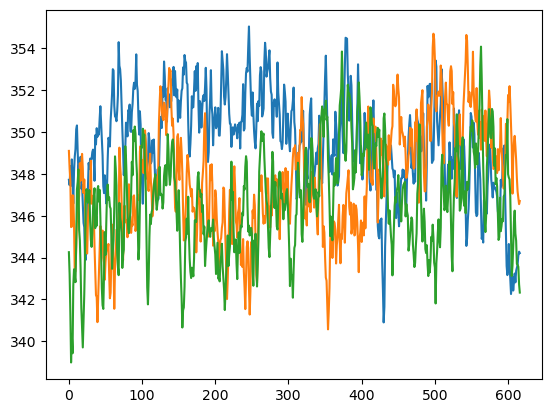

In [725]:
y1 = np.random.multivariate_normal(
    mean= mean, cov = K(X,X).detach().numpy(),
    size=3)
plt.plot(y1.T, '-')
# plt.plot(Y, '.');

In [1310]:
list(K.parameters())

[Parameter containing:
 tensor([0.8656], requires_grad=True),
 Parameter containing:
 tensor([2.7278], requires_grad=True),
 Parameter containing:
 tensor([3.8929], requires_grad=True),
 Parameter containing:
 tensor([1.3931], requires_grad=True),
 Parameter containing:
 tensor([2.3562], requires_grad=True),
 Parameter containing:
 tensor([0.2800], requires_grad=True),
 Parameter containing:
 tensor([6.5890], requires_grad=True),
 Parameter containing:
 tensor([0.3680], requires_grad=True),
 Parameter containing:
 tensor([1.1674], requires_grad=True)]

In [49]:
import gpytorch


In [92]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X, Y, likelihood)

In [75]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: likelihood.noise_covar.raw_noise           value = 0.0
Parameter name: mean_module.raw_constant                   value = 0.0
Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0


In [77]:
def predict(model, likelihood, test_x = torch.linspace(0, 1, 51)):
    model.eval()
    likelihood.eval()
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Test points are regularly spaced along [0,1]
        return likelihood(model(test_x))

In [93]:
observed_pred = predict(model, likelihood)

In [101]:
def plot(observed_pred, test_x=torch.linspace(0, 1, 51)):
    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(4, 3))

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        # Plot training data as black stars
        # ax.plot(X.numpy(), train_y.numpy(), 'k*')
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Mean', 'Confidence'])

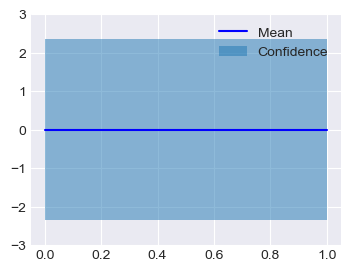

In [102]:
plot(observed_pred)

In [59]:
gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())(X)